In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from sklearn import preprocessing
from scipy import stats
from itertools import combinations

from news_vec.utils import read_json_gz_lines

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [4]:
df = pd.DataFrame(list(tqdm(read_json_gz_lines('../data/clf-ab-ts-acc.json/'))))

1092000it [00:02, 385636.01it/s]


In [5]:
d1s, d2s = zip(*df[['d1', 'd2']].apply(lambda x: sorted(x), 1))
df.drop(['d1', 'd2'], 1)
df['d1'] = d1s
df['d2'] = d2s

In [6]:
aud_corr = pd.read_json('../data/window-actor-corrs2.json/part-00000-8549d2df-1b6a-4ecd-8c88-3b7025d29ec5-c000.json', lines=True)

In [8]:
d1s, d2s = zip(*aud_corr[['d1', 'd2']].apply(lambda x: sorted(x), 1))
aud_corr.drop(['d1', 'd2'], 1)
aud_corr['d1'] = d1s
aud_corr['d2'] = d2s

In [9]:
pairs = set(map(tuple, df[['d1', 'd2']].values.tolist()))

In [71]:
def plot_pair(d1, d2):
    
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    
    plt.figure(figsize=(8,3))
    sns.boxplot(x='window', y='acc', data=pdf)
    plt.show()
    
    plt.figure(figsize=(8,3))
    plt.ylim(-1,1)
    pdf = aud_corr[(aud_corr.d1==d1)&(aud_corr.d2==d2)].sort_values('window')
    plt.plot(pdf.window, pdf['corr'])
    plt.show()

In [15]:
rows = []
for d1, d2 in tqdm(pairs):
    pdf = df[(df.d1==d1)&(df.d2==d2)].sort_values('window')
    lr = stats.linregress(pdf.window, pdf.acc)
    rows.append((d1, d2, lr.slope, lr.pvalue, lr.rvalue))

100%|██████████| 120/120 [00:26<00:00,  4.54it/s]


In [16]:
lrdf = pd.DataFrame(rows, columns=('d1', 'd2', 'slope', 'p', 'r'))

buzzfeed.com huffingtonpost.com


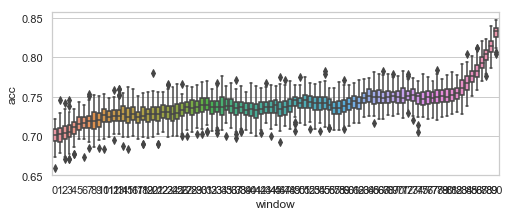

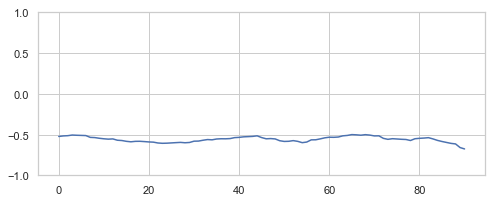

foxnews.com rt.com


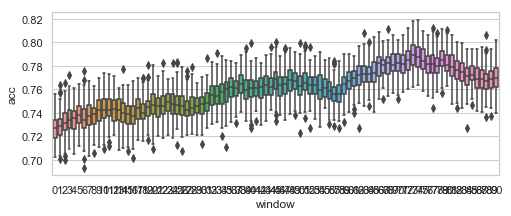

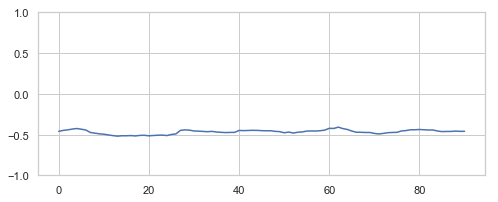

buzzfeed.com foxnews.com


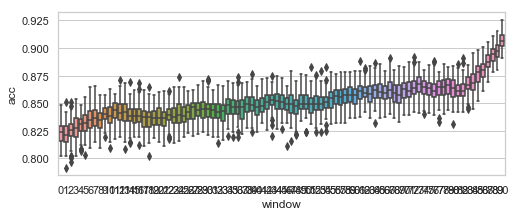

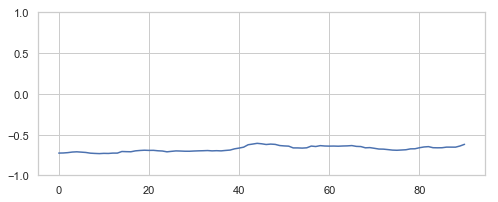

foxnews.com wsj.com


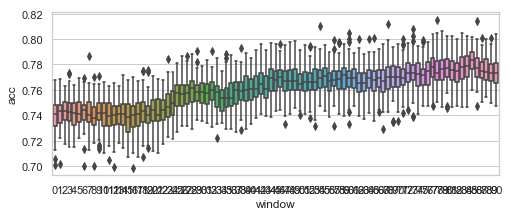

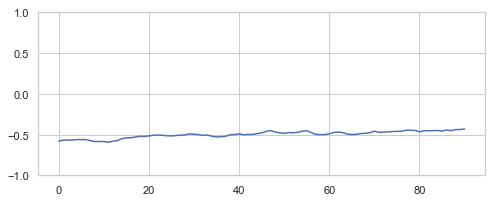

apnews.com foxnews.com


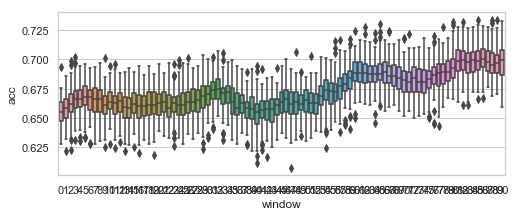

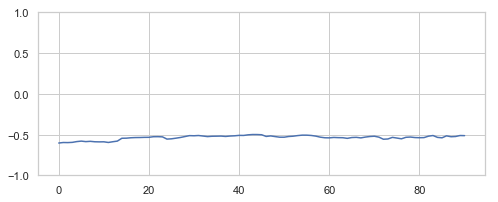

In [72]:
for r in lrdf.sort_values('slope', ascending=False).head(5).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

huffingtonpost.com thehill.com


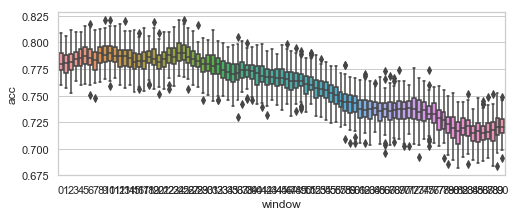

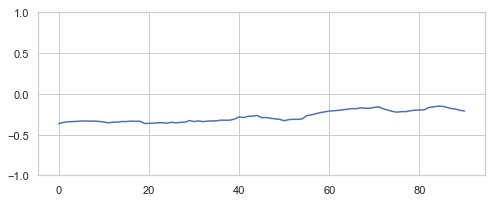

dailykos.com huffingtonpost.com


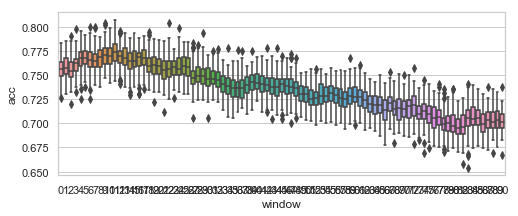

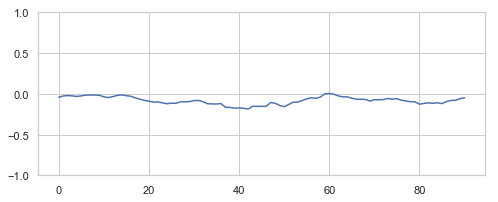

rt.com sputniknews.com


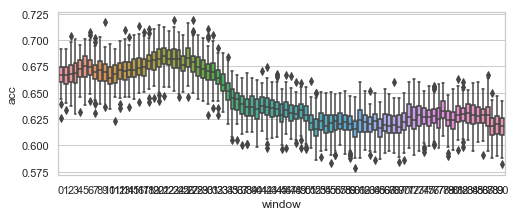

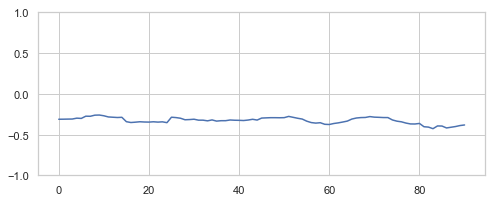

cnn.com huffingtonpost.com


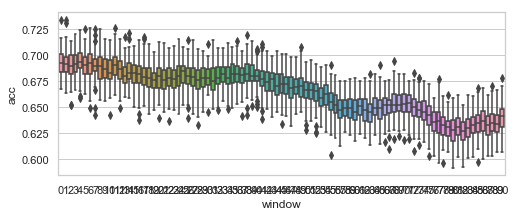

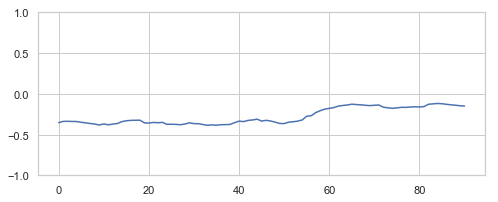

cnn.com dailykos.com


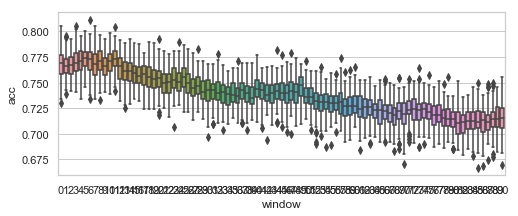

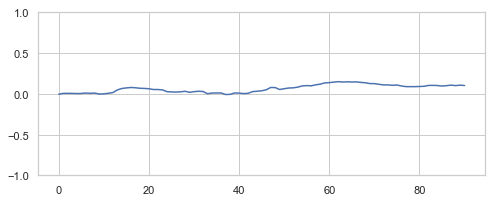

In [73]:
for r in lrdf.sort_values('slope', ascending=True).head(5).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

In [74]:
mean_accs = df.groupby(['d1', 'd2', 'window']).mean()

In [75]:
ca = mean_accs.merge(aud_corr, left_index=True, right_on=['d1', 'd2', 'window'])

In [81]:
stats.kendalltau(ca.acc, ca['corr'])

KendalltauResult(correlation=-0.25451846013917495, pvalue=0.0)

In [77]:
rows = []
for d1, d2 in pairs:
    pdf = ca[(ca.d1==d1)&(ca.d2==d2)]
    corr, p = stats.kendalltau(pdf.acc, pdf['corr'])
    rows.append((d1, d2, corr, p))

In [78]:
ca_pairs = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))

In [79]:
ca_pairs.sort_values('corr')

,d1,d2,corr,p
31,huffingtonpost.com,thehill.com,-0.742125,2.041988e-25
71,dailycaller.com,rt.com,-0.611722,8.866098e-18
96,cnn.com,huffingtonpost.com,-0.590720,1.104681e-16
104,npr.org,thehill.com,-0.560440,3.607817e-15
88,apnews.com,thehill.com,-0.539438,3.646407e-14
38,buzzfeed.com,dailycaller.com,-0.522833,2.137529e-13
36,cnn.com,npr.org,-0.515018,4.822970e-13
99,cnn.com,dailykos.com,-0.499878,2.256404e-12
9,huffingtonpost.com,washingtonpost.com,-0.478877,1.782481e-11
87,buzzfeed.com,sputniknews.com,-0.461294,9.419892e-11


huffingtonpost.com thehill.com


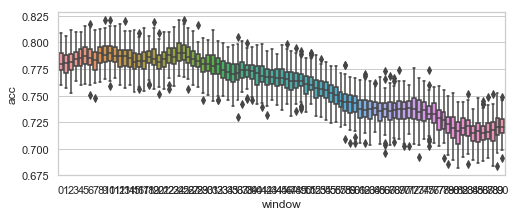

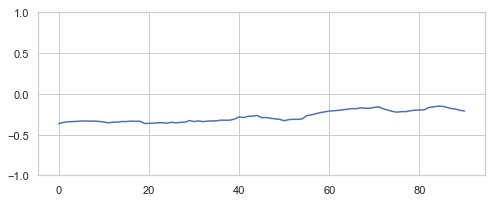

dailycaller.com rt.com


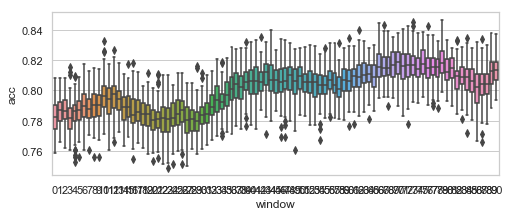

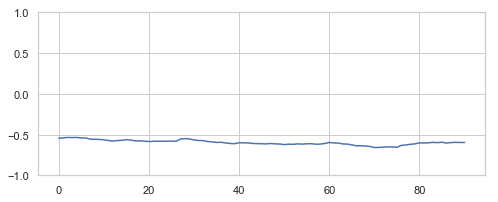

cnn.com huffingtonpost.com


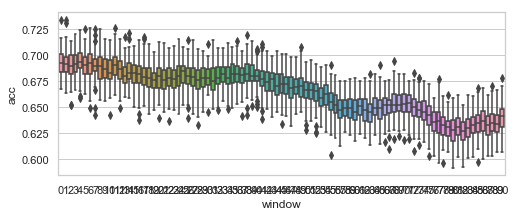

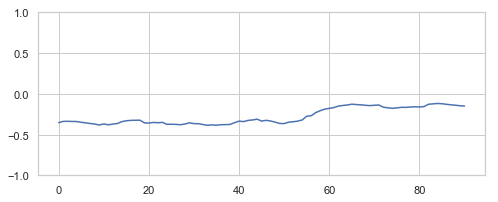

npr.org thehill.com


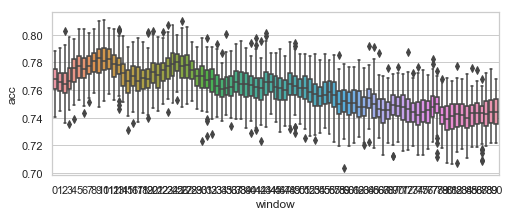

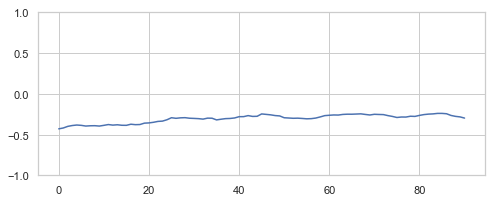

apnews.com thehill.com


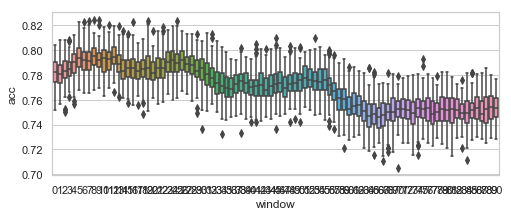

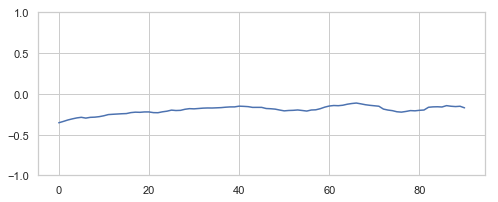

In [80]:
for r in ca_pairs.sort_values('corr', ascending=True).head(5).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)

foxnews.com wsj.com


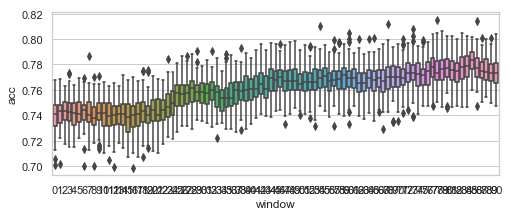

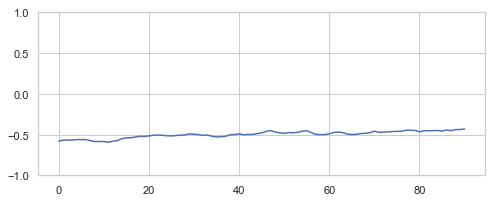

breitbart.com foxnews.com


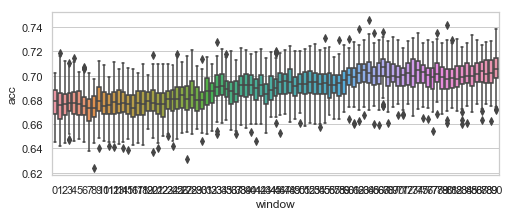

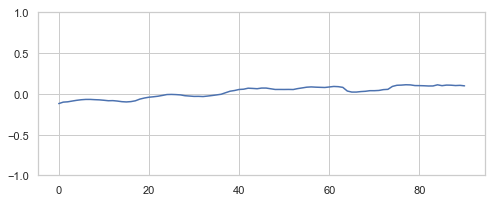

apnews.com rt.com


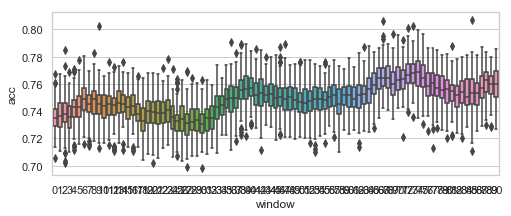

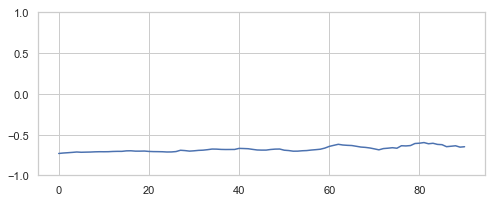

dailycaller.com huffingtonpost.com


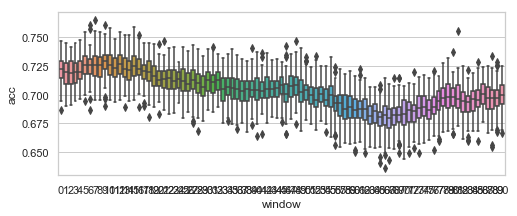

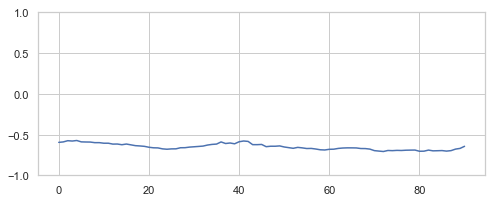

buzzfeed.com foxnews.com


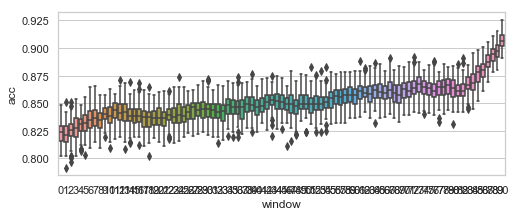

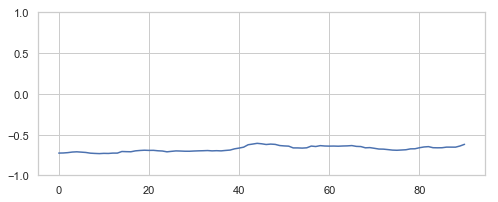

In [59]:
for r in ca_pairs.sort_values('corr', ascending=False).head(5).itertuples():
    print(r.d1, r.d2)
    plot_pair(r.d1, r.d2)